In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
SELECT distinct(date_trunc('month', creation_date)::date) as month_date,
sum(views_count) over (PARTITION BY date_trunc('month', creation_date)::date) as total_views
FROM stackoverflow.posts
WHERE date_trunc('year', creation_date) = '2008-01-01'
ORDER BY total_views desc
;
'''
sample_df = pd.read_sql_query(query, con=engine) 
# выполните запрос

In [7]:
sample_df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


<details>

<summary>Подсказка</summary>
Используйте функцию для усечения даты, а затем сгруппируйте и отсортируйте данные.
</details>

Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

Данные отличаются. Особеено это заметно разницой между 7, 8 и 9-м месяцем. Такие резкие изменения могут быть связаны с тем, что c июле 2008 года, только начали создавать данную базу. После сентября начался постепенный спад. Но к сожалению нельзя понять почему он именно произошел, так как мы не знаем полной картины(возможно дальше опять идет прирост). Можно предположить, что в сентябре произашла сезонная активность, а к декаблю она немного упала.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [8]:
# напишите запрос
query = '''
With post_answer as
(SELECT *
from stackoverflow.posts
WHERE post_type_id = (
SELECT id
FROM stackoverflow.post_types
Where type = 'Answer')),

user_info as
(select id,
 display_name,
 creation_date,
 creation_date + interval'1 month' as month_end
from stackoverflow.users)

select distinct(ui.display_name),
count(distinct(pa.user_id))
from user_info as ui
join post_answer as pa on ui.id = pa.user_id and pa.creation_date >=ui.creation_date and pa.creation_date <=ui.month_end
group by ui.display_name 
having count(distinct(pa.id))>100
order by 1
'''
sample_df = pd.read_sql_query(query, con=engine)
# выполните запрос

In [9]:
sample_df 

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
71,leppie,1
72,lomaxx,1
73,mattlant,1
74,paxdiablo,1


<details>

<summary>Подсказка</summary>
Вам нужно присоединить несколько таблиц — изучите внимательнее описание базы. Чтобы добавить промежуток времени к дате, используйте ключевое слово INTERVAL, например, так: <дата> + INTERVAL '1 year 2 months 3 days'
.</details>

Какие аномалии наблюдаются в данных? О чём они говорят?

Видно,что некоторые имена имеют несколько уникальных индетификационных нормера. Это значит что существует возможность регистрирования с одинаковыми именами. Это не совсем коррескто, так как в будущем будет сложнее работать с базами данных содержащими одинаковые имена.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [10]:
# напишите запрос
query = '''
with users_month as
(SELECT id
FROM stackoverflow.users
WHERE date_trunc('month',creation_date)::date = '2008-09-01'),
posts_month as
(SELECT sp.user_id
FROM stackoverflow.posts as sp
JOIN users_month as um on sp.user_id = um.id
WHERE date_trunc('month',sp.creation_date)::date = '2008-12-01')

SELECT date_trunc('month',sp.creation_date)::date as month,
COUNT(distinct(sp.id)) as count
FROM stackoverflow.posts as sp
JOIN posts_month as pm on sp.user_id = pm.user_id
WHERE date_trunc('year',sp.creation_date)::date = '2008-01-01'
group by date_trunc('month',sp.creation_date)::date
order by month desc
'''
sample_df = pd.read_sql_query(query, con=engine) 
# выполните запрос

In [11]:
sample_df

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


<details>

<summary>Подсказка</summary>
Сначала найдите идентификаторы пользователей, которые зарегистрировались в сентябре 2008 года и оставили хотя бы один пост в декабре. Затем используйте результат для среза и посчитайте посты по месяцам.</details>

Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

В августе самое маленькое колличество постов. Это пожет быть связано с какой-то ошибкой на сайте, из-за которой люди не могли писать посты.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [12]:
# напишите запрос
query = '''
SELECT user_id,
creation_date,
views_count,
sum(views_count) over (order by user_id,creation_date) as cumulative_count
FROM stackoverflow.posts
'''
sample_df = pd.read_sql_query(query, con=engine) 
# выполните запрос

In [13]:
sample_df

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,1369918176
243792,5696608,2008-12-23 17:35:09,0,1369918176
243793,5696608,2008-12-24 01:02:48,0,1369918176
243794,5696608,2008-12-30 14:34:45,0,1369918176


<details>

<summary>Подсказка</summary>
Для подсчёта суммы с накоплением используйте оконную функцию.
</details>

# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [14]:
# напишите запрос
query = '''
with count_posts as
(SELECT user_id
FROM stackoverflow.posts
WHERE date_trunc('month',creation_date)::date = '2008-08-01'
group by user_id
HAVING count(id)>120),

day_count as
(SELECT sp.user_id,
count(sp.id) as count_u,
sp.creation_date::date
FROM stackoverflow.posts as sp
JOIN count_posts as cp on sp.user_id=cp.user_id
WHERE date_trunc('month',sp.creation_date)::date = '2008-08-01'
GROUP BY sp.user_id,sp.creation_date::date)
    
SELECT user_id,
AVG(count_u) as avg_daily 
FROM day_count
GROUP BY user_id
ORDER BY avg_daily
'''
sample_df = pd.read_sql_query(query, con=engine) 
# выполните запрос

In [15]:
sample_df

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


<details>

<summary>Подсказка</summary>
Сначала найдите идентификаторы пользователей, которые написали более 120 постов за август. Используя этот запрос в качестве подзапроса для среза, найдите и сохраните во временную таблицу идентификаторы нужных пользователей, дни августа и количество постов в день. В основном запросе сгруппируйте данные по пользователям и найдите для каждого из них среднее количество постов.
</details>

# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [16]:
# напишите запрос
query = '''
SELECT ROUND(AVG (count_date)) as result
FROM (SELECT user_id,
count(distinct(creation_date::date)) as count_date
FROM stackoverflow.posts
where creation_date::date >= '2008-12-01' and creation_date::date <= '2008-12-07'
group by user_id) as count_date
'''
sample_df = pd.read_sql_query(query, con=engine) 
# выполните запрос

In [17]:
sample_df

,result
0,2.0


<details>

<summary>Подсказка</summary>
Посчитайте, сколько активных дней было у каждого пользователя. Добавьте данные во временную таблицу и используйте в основном запросе.
</details>

Проанализируйте итоговую таблицу — какие выводы можно сделать?

В среднем, пользователи взаимодействовали с платформой 2 дня. Это ниже среденего значения.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [18]:
# напишите запрос
query = '''
with user_date_lag as
(SELECT *,
LAG(creation_date, 2, NULL) OVER (PARTITION BY user_id ORDER BY creation_date) as lag_date
FROM (SELECT user_id,
creation_date
FROM stackoverflow.posts as sp
order by 1,2) as post_date)

SELECT user_id,
creation_date,
CASE WHEN lag_date IS NOT NULL THEN TO_CHAR(lag_date, 'Month') ELSE 'None' END
FROM user_date_lag
'''
sample_df = pd.read_sql_query(query, con=engine) 
# выполните запрос

In [19]:
sample_df

,user_id,creation_date,case
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


<details>

<summary>Подсказка</summary>
Преобразовать результат оконной функции в нужное значение вам поможет аналог условного оператора в SQL: CASE <поле> WHEN <старое значение> THEN <новое значение> END.
</details>

# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [20]:
query = '''
WITH profile AS
(SELECT user_id,
       min_date,
       COUNT(*) OVER (PARTITION BY min_date) AS cohort_users_cnt
       FROM(
SELECT user_id,
       date_trunc('Month',MIN(creation_date)) as min_date
FROM   stackoverflow.posts
GROUP BY user_id
           ) as t), 
sessions AS
(SELECT user_id,
date_trunc('month',creation_date) AS session_date
FROM stackoverflow.posts
GROUP BY 1,
2)

SELECT p.min_date,
s.session_date,
COUNT(s.user_id) as users_cnt,
p.cohort_users_cnt,
ROUND(COUNT(s.user_id) * 100.0 / p.cohort_users_cnt, 2) as retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
2,
4
ORDER BY 1, 2;

'''
sample_df = pd.read_sql_query(query, con=engine) 
# выполните запрос

In [21]:
sample_df

,min_date,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


<details>

<summary>Подсказка</summary>
Вспомните, как выглядел запрос для расчёта Retention Rate в теории. Создайте две временные таблицы: `profile` и `sessions` (в ней будет информация о публикациях), а затем используйте их в основном запросе.

Во временной таблице `profile` вам понадобятся три поля:

- идентификатор пользователя;
- дата первого поста пользователя, усечённая до месяца (признак начала когорты);
- количество пользователей этой когорты.
</details>

Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

In [22]:
# постройте тепловую карту Retention Rate
# создаём сводную таблицу с результатами
retention = sample_df.pivot('min_date', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

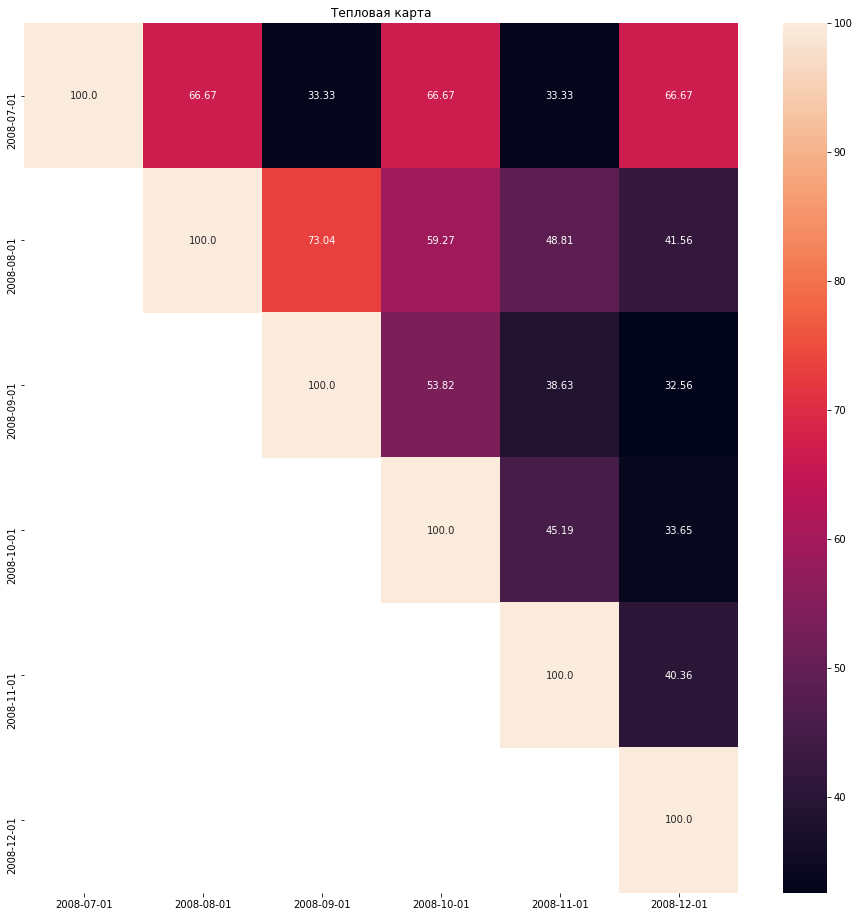

In [23]:
# строим хитмэп
plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

В когорте от 2008-07-01, Retention Rate имеет скочкообразный вид, что выглядит странно. Возможно ппользователи этой когорты через какое-то время возвращались и писали посты. Хотя четкость цыфр тоже настораживает. Так же заметно, что чем позже начало когорты, тем меньше процент удержания.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [24]:
# напишите запрос
query = '''
With posts_lag_count as
(SELECT EXTRACT(MONTH FROM creation_date::date) as creation_month,
count(id) as posts_count,
ROUND ((count(id)::numeric/LAG(count(id),1,count(id)) over (order by EXTRACT(MONTH FROM creation_date::date))*100), 2) as lag_posts_count
FROM (SELECT *
FROM stackoverflow.posts
where date_trunc('day',creation_date)::date >='2008-09-01' and date_trunc('day',creation_date)::date <='2008-12-31') as day_date
group by creation_month
order by 1)

SELECT creation_month,
posts_count,
lag_posts_count::numeric - LAG(lag_posts_count,1,NULL) over (ORDER by creation_month) as percentage
FROM posts_lag_count
'''
sample_df = pd.read_sql_query(query, con=engine) 
# выполните запрос

In [25]:
sample_df

,creation_month,posts_count,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-15.23
3,12.0,44592,20.49


<details>

<summary>Подсказка</summary>
Эту задачу стоит декомпозировать. Сформируйте запрос, который отобразит номер месяца и количество постов. Затем можно использовать оконную функцию, которая вернёт значение за предыдущий месяц, и посчитать процент.
</details>

Постройте круговую диаграмму с количеством постов по месяцам.

<AxesSubplot:ylabel='posts_count'>

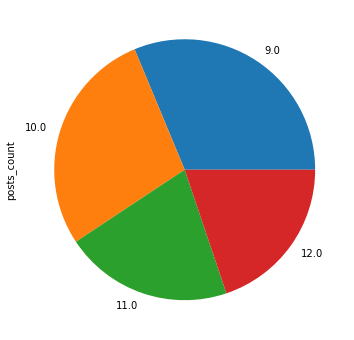

In [26]:
sample_df.set_index('creation_month', inplace=True)
sample_df['posts_count'].plot(kind='pie', figsize=(6,6))# постройте круговую диаграмму с количеством постов по месяцам

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [27]:
# напишите запрос
query = '''
with user_post as
(SELECT user_id,
count(id) as count_post
FROM stackoverflow.posts
group by user_id
order by count_post desc limit 1)

SELECT extract(week from date_trunc('week',sp.creation_date)::date) as week_date,
max(sp.creation_date) 
FROM stackoverflow.posts as sp
join user_post as up on sp.user_id = up.user_id
where date_trunc('month',creation_date)::date = '2008-10-01'
group by week_date
'''
sample_df = pd.read_sql_query(query, con=engine) 
# выполните запрос

In [28]:
sample_df

,week_date,max
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01


<details>

<summary>Подсказка</summary>
Декомпозируйте задачу:
1) Найдите пользователя, который опубликовал больше всего постов. 2) Найдите дату и время создания каждого поста этого пользователя и номер недели. 
3) Отобразите данные только о последних постах пользователя. Для этого можно использовать оконную функцию.
</details>

# Выводы

1) Общая сумма просмотров постов за каждый месяц 2008 года отличаются. Особеено это заметно разницой между 7, 8 и 9-м месяцем. Такие резкие изменения могут быть связаны с тем, что c июле 2008 года, только начали создавать данную базу. После сентября начался постепенный спад. Но к сожалению нельзя понять почему он именно произошел, так как мы не знаем полной картины(возможно дальше опять идет прирост). Можно предположить, что в сентябре произашла сезонная активность, а к декаблю она немного упала.

2) Имена самых активных пользователей имеют несколько уникальных индетификационных нормера. Это значит что существует возможность регистрирования с одинаковыми именами. Это не совсем коррескто, так как в будущем будет сложнее работать с базами данных содержащими одинаковые имена.

3) В августе 2008 самое маленькое колличество постов за весь 2008 год. Это пожет быть связано с какой-то ошибкой на сайте, из-за которой люди не могли писать посты.

4) В среднем, в период с 1 по 7 декабря 2008 года, пользователи взаимодействовали с платформой 2 дня. Это ниже среденего значения.

5) В когорте от 2008-07-01, Retention Rate имеет скочкообразный вид, что выглядит странно. Возможно ппользователи этой когорты через какое-то время возвращались и писали посты. Хотя четкость цыфр тоже настораживает. Так же заметно, что чем позже начало когорты, тем меньше процент удержания.